In [43]:
# ###################################
# Group ID: 222
# Members: Adrián Gómez Repollés, Kresten Johansen, Misbah Unnisa, Mohammadali Zakeriharandi
# Date: 19/06/2024
# Lecture: Lecture 4: Dimensionality reduction
# Dependencies: Numpy, Scipy,  Matplotlib, Scikit-Learn
# Python version: 3.10.13
# Functionality: Jupyter notebook to apply dimensionality reduction on 3 classes of MNIST dataset
# ###################################

In [44]:
%reload_ext watermark
%watermark -v -p numpy,scipy,sklearn

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.15.0

numpy  : 1.21.5
scipy  : 1.7.3
sklearn: 1.1.1



# Day 2
- Work with `mnist_all.mat` data file
- Create a function to estimate PCA, returning eigenvalues and eigenvectors, and the mean of your data
- Create a function to apply PCA on your data returning the projected data
- Create a function to reconstruct the projected data
- Train a Gaussian Mixture Model on the reduced data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import eig, eigh
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.mixture import GaussianMixture

## Exercise 1.a. Dimensionality Reduction

### Load Data

In [2]:
data_path="./data/mnist_all.mat"
data_mat = loadmat(data_path)

print(data_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'train0', 'test0', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3', 'train4', 'test4', 'train5', 'test5', 'train6', 'test6', 'train7', 'test7', 'train8', 'test8', 'train9', 'test9'])


In [3]:
data_tr = np.concatenate((data_mat["train5"].astype(np.float32) / 255, 
                        data_mat["train6"].astype(np.float32) / 255, 
                        data_mat["train8"].astype(np.float32) / 255), axis=0)
targets_tr = np.concatenate(
    (5*np.ones(data_mat["train5"].shape[0]), 
    6*np.ones(data_mat["train6"].shape[0]),
    8*np.ones(data_mat["train8"].shape[0]))
)

print("Training Data:")
print(data_tr.shape)
print(targets_tr.shape)

data_ts = np.concatenate((data_mat["test5"].astype(np.float32) / 255, 
                        data_mat["test6"].astype(np.float32) / 255, 
                        data_mat["test8"].astype(np.float32) / 255), axis=0)
targets_ts = np.concatenate(
    (5*np.ones(data_mat["test5"].shape[0]), 
    6*np.ones(data_mat["test6"].shape[0]),
    8*np.ones(data_mat["test8"].shape[0]))
)
print("\nTest Data:")
print(data_ts.shape)
print(targets_ts.shape)

Training Data:
(17190, 784)
(17190,)

Test Data:
(2824, 784)
(2824,)


### Visualize Data

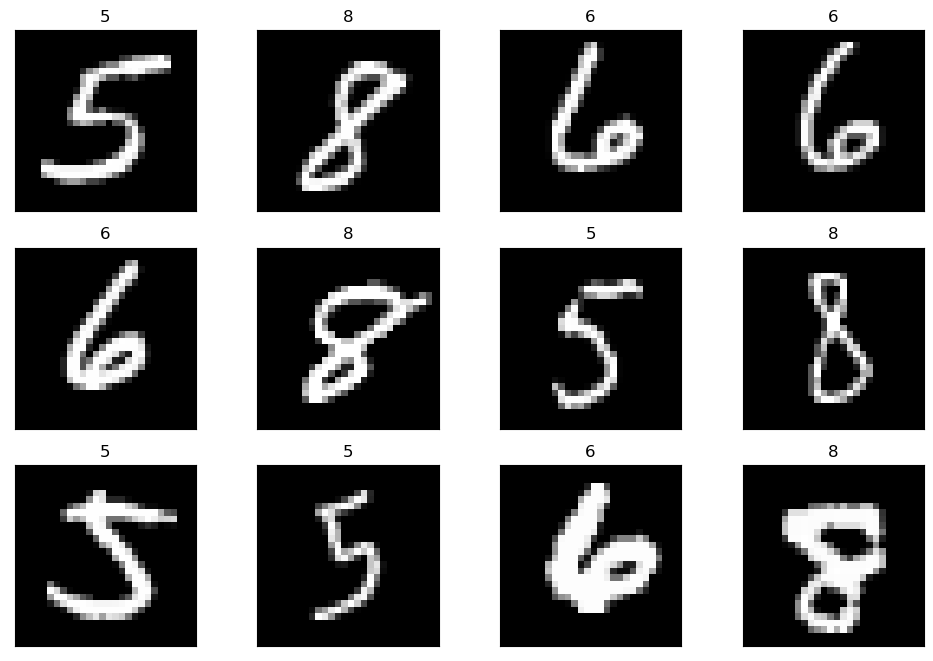

In [4]:
rng = np.random.default_rng(42)
idxs = rng.integers(0, len(data_tr), 12)

fig, axs = plt.subplots(3, 4, figsize=(12, 8))
for idx, ax in zip(idxs, axs.flatten()):
    data = data_tr[idx, :].reshape(28, 28)
    label = targets_tr[idx]

    ax.imshow(data, cmap="gray")
    ax.set_title(int(label))
    ax.set_xticks([])
    ax.set_yticks([])

### Compute PCA

In [5]:
def compute_pca(data, n_components=2):
    data_mean = np.mean(data, axis=0)
    data_str = data - data_mean  # standardized data

    data_cov = np.cov(data_str.T)  # covariance matrix
    eigval, eigvec = eigh(data_cov)  # eigen decomposition

    # Sort in descending order
    idxs = eigval.argsort()[::-1]
    eigval = eigval[idxs]
    eigvec = eigvec[:, idxs]

    # Choose first n_components
    eigval = eigval[:n_components]
    eigvec = eigvec[:, :n_components]

    return eigval, eigvec, data_mean

In [6]:
n_components = 2  # no. PCs
eigval, eigvec, data_mean = compute_pca(data_tr, n_components)

print(eigval.shape)
print(eigvec.shape)

(2,)
(784, 2)


### Apply PCA

In [7]:
def apply_pca(data, n_components=2):
    _, eigvec, data_mean = compute_pca(data, n_components)
    data_str = data - data_mean
    data_red = data_str @ eigvec  # projection
    return data_red

In [8]:
data_red = apply_pca(data_tr, n_components)
print(data_red.shape)

(17190, 2)


### Reconstruct Data

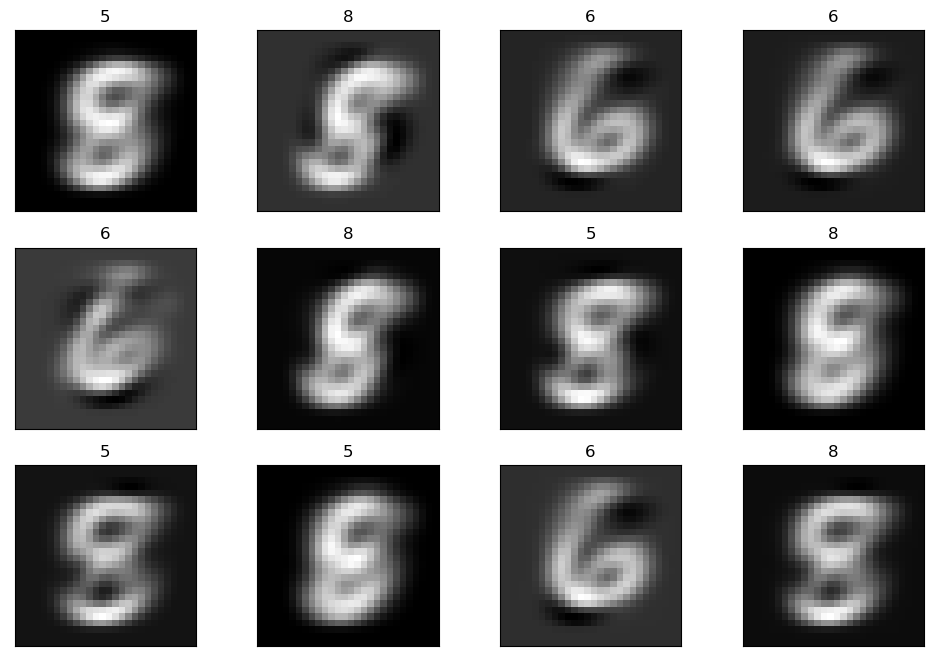

In [9]:
data_rec = data_red @ eigvec.T + data_mean

rng = np.random.default_rng(42)
idxs = rng.integers(0, len(data_rec), 12)

fig, axs = plt.subplots(3, 4, figsize=(12, 8))
for idx, ax in zip(idxs, axs.flatten()):
    data = data_rec[idx, :].reshape(28, 28)
    label = targets_tr[idx]

    ax.imshow(data, cmap="gray")
    ax.set_title(int(label))
    ax.set_xticks([])
    ax.set_yticks([])

It is observed, that even choosing 2 principal components can reconstruct the data in a distinguishable manner. Ideally, one may choose the optimal number of eigenvalues by computing the Proportion of Variance (PoV). 

## Exercise 1.b. Classification

In [10]:
X_tr, y_tr = data_red, targets_tr.astype(int)
X_ts, y_ts = apply_pca(data_ts, n_components), targets_ts.astype(int)

print(X_tr.shape, y_tr.shape)
print(X_ts.shape, y_ts.shape)

(17190, 2) (17190,)
(2824, 2) (2824,)


In [11]:
model = RandomForestClassifier(n_estimators=3)
model.fit(X_tr, y_tr)

RandomForestClassifier(n_estimators=3)

Training accuracy 0.9319371727748691


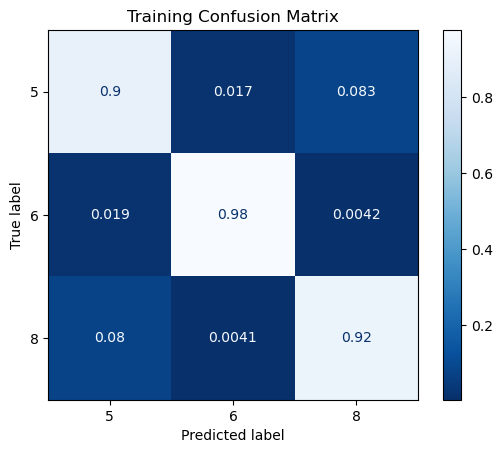

Test accuracy 0.5609065155807366


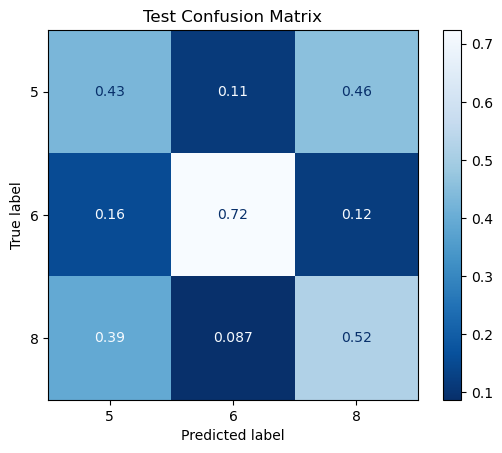

In [12]:
acc_tr = accuracy_score(y_tr, model.predict(X_tr))
print("Training accuracy", acc_tr)
cm_tr = confusion_matrix(y_tr, model.predict(X_tr), normalize="true")
ph = ConfusionMatrixDisplay(cm_tr, display_labels=["5", "6", "8"])
fig, ax = plt.subplots()
ph.plot(ax=ax, cmap="Blues_r")
ax.set_title("Training Confusion Matrix")
plt.show()

acc_ts = accuracy_score(y_ts, model.predict(X_ts))
print("Test accuracy", acc_ts)
cm_ts = confusion_matrix(y_ts, model.predict(X_ts), normalize="true")
ph = ConfusionMatrixDisplay(cm_ts, display_labels=["5", "6", "8"])
fig, ax = plt.subplots()
ph.plot(ax=ax, cmap="Blues_r")
ax.set_title("Test Confusion Matrix")
plt.show()


The high training but low test accuracies on test data could indicate that: 
- we need to increase the no. PCs to avoid information loss while projection
- RandomForest is not probably the most suitable model for dealing with this data and it is over-fitting the training data

## Exercise 2 - Gaussian Mixture Model


In [13]:
gmm = GaussianMixture(n_components=3, covariance_type="full")
gmm.fit(X_tr)

GaussianMixture(n_components=3)

In [14]:
labels = [5, 6, 8]

for label in labels:
    cluster_ts = gmm.predict(X_ts[y_ts==label])
    print(np.unique(cluster_ts, return_counts=True))

(array([0, 1, 2]), array([446, 419,  27]))
(array([0, 1, 2]), array([271,   6, 681]))
(array([0, 1, 2]), array([363, 591,  20]))


It is observed, for each class, GMM was succesful (almost) to assign samples of projected samples into the same cluster. 